In [1]:
import torch
#%matplotlib nbagg
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import mplhep as hep

hep.style.use("CMS")


df = pd.read_parquet(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\merged_nominal.parquet')

with open(r'C:\Users\drpla\Desktop\ICL-PHYSICS-YEAR-4\Masters Project\Data\New folder\summary.json', "r") as f:
  proc_dict = json.load(f)["sample_id_map"]
  
signalname="GluGluToRadionToHHTo2G2Tau_M-1000"
sig = df[df.process_id == proc_dict[f"{signalname}"]] # just one signal process, mass of X is 1000 GeV
sig['Classification']=np.ones(sig['Diphoton_mass'].size)


C:\Users\drpla\AppData\Local\Temp\ipykernel_1476\970617314.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig['Classification']=np.ones(sig['Diphoton_mass'].size)


In [2]:
proc_dict

{'Data': 0,
 'DiPhoton': 3,
 'GluGluToRadionToHHTo2G2Tau_M-1000': -195,
 'GluGluToRadionToHHTo2G2Tau_M-250': -196,
 'GluGluToRadionToHHTo2G2Tau_M-260': -197,
 'GluGluToRadionToHHTo2G2Tau_M-270': -198,
 'GluGluToRadionToHHTo2G2Tau_M-280': -199,
 'GluGluToRadionToHHTo2G2Tau_M-290': -200,
 'GluGluToRadionToHHTo2G2Tau_M-300': -201,
 'GluGluToRadionToHHTo2G2Tau_M-320': -202,
 'GluGluToRadionToHHTo2G2Tau_M-350': -203,
 'GluGluToRadionToHHTo2G2Tau_M-400': -204,
 'GluGluToRadionToHHTo2G2Tau_M-450': -205,
 'GluGluToRadionToHHTo2G2Tau_M-500': -206,
 'GluGluToRadionToHHTo2G2Tau_M-550': -207,
 'GluGluToRadionToHHTo2G2Tau_M-600': -208,
 'GluGluToRadionToHHTo2G2Tau_M-650': -209,
 'GluGluToRadionToHHTo2G2Tau_M-700': -210,
 'GluGluToRadionToHHTo2G2Tau_M-750': -211,
 'GluGluToRadionToHHTo2G2Tau_M-800': -212,
 'GluGluToRadionToHHTo2G2Tau_M-900': -213,
 'TTGG': 7,
 'TTGamma': 6,
 'TTJets': 5,
 'VBFH_M125': 12,
 'VH_M125': 9,
 'WGamma': 4,
 'ZGamma': 2,
 'ggH_M125': 11,
 'ttH_M125': 10,
 'GJets': 8}

In [3]:
"""Concatenating the background data"""
background_list=['Data','DiPhoton', 'TTGG', 'TTGamma',#list of each bkgs for concatenation
 'TTJets',
 'VBFH_M125',
 'VH_M125',
 'WGamma',
 'ZGamma',
 'ggH_M125', 
 'ttH_M125',
 'GJets']

listforconc=[]
for i in background_list:                               #creating a concatenated list of bkg
    bkgg = df[df.process_id == proc_dict[i]]
    listforconc.append(bkgg)
    
background = pd.concat(listforconc)
background['Classification']=np.zeros(background['Diphoton_mass'].size)

In [4]:
"""The features requiring exclusion of -9 values"""
MinusNineBinning=['ditau_met_dPhi',
                  'ditau_deta',
                  'ditau_dR',
                  'ditau_dphi',
                  'ditau_pt',
                  'Diphoton_ditau_dphi',
                  'dilep_leadpho_mass',
                  'reco_MX_mgg',
                  'Diphoton_ditau_deta',
                  'Diphoton_sublead_lepton_deta',
                  'Diphoton_sublead_lepton_dR',
                  'LeadPhoton_ditau_dR',
                  'ditau_mass']


In [5]:
"""Concatenating Signal and Background"""
"""Choosing Best Features given the M=1000 AUC scores"""
FullSignalBackground=pd.concat([sig,background])

df_TopFeatures=pd.DataFrame()

TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','Diphoton_lead_lepton_deta','ditau_met_dPhi','ditau_deta','Diphoton_sublead_lepton_deta','Diphoton_ditau_deta','ditau_mass','weight_central','Classification']
# includes classification and weights
#TopFeatures=['reco_MX_mgg','Diphoton_pt_mgg','LeadPhoton_pt_mgg','ditau_pt','Diphoton_dPhi','dilep_leadpho_mass','lead_lepton_pt','MET_pt','ditau_dR','SubleadPhoton_pt_mgg','weight_central','Classification']

"""A dataset consisting of only the essential features"""
for feature in TopFeatures:
    df_TopFeatures[feature]=FullSignalBackground[feature]
    
"""Removal of the values that are binned at -9 from the necessary features"""
for columns in df_TopFeatures.columns:
    if columns in MinusNineBinning:
        df_TopFeatures = df_TopFeatures.loc[(df_TopFeatures[columns] > -8)]


In [6]:
df_TopFeatures = df_TopFeatures.sample(frac=1, random_state=42)  # Setting frac=1 shuffles all rows

features = df_TopFeatures # Extracting features

labels = df_TopFeatures['Classification']  # Extracting labels

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=(1/3), random_state=42)
test_weights=pd.DataFrame()
train_weights=pd.DataFrame()

weightofsignal=train_features[train_features['Classification']==1]['weight_central'].sum()
weightofbackground=train_features[train_features['Classification']==0]['weight_central'].sum()
scale=weightofsignal/weightofbackground

"""reweighting the weight_central column in entire data 
set such that for background and signal """
train_features.loc[train_features['Classification'] == 0, 'weight_central'] *= scale
test_features.loc[test_features['Classification'] == 0, 'weight_central'] *= scale


train_weights['weight_central']=train_features['weight_central']
test_weights['weight_central']=test_features['weight_central']



train_features = train_features.drop(columns=['weight_central'])
train_features = train_features.drop(columns=['Classification'])
test_features=test_features.drop(columns=['weight_central'])

train_features_tensor = torch.tensor(train_features.values, dtype=torch.float32)
train_weights_tensor = torch.tensor(train_weights.values,dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values,dtype=torch.float32)



In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN,self).__init__()
#         self.hidden1 = nn.Linear(16, 20)
#         self.act1 = nn.ReLU()
#         self.hidden2 = nn.Linear(20, 8)
#         self.act2 = nn.ReLU()
#         self.output = nn.Linear(8, 1)
        self.hidden1 = nn.Linear(16, 20)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(20, 40)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(40, 16)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(16, 8)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.hidden3(x)
        x = self.act3(x)
        x = self.hidden4(x)
        x = self.act4(x)
        x = self.output(x)
        x = self.act_output(x)
        return x


    def weightedBCELoss(self, input, target, weight):
      x, y, w = input, target, weight
      log = lambda x: torch.log(x*(1-1e-8) + 1e-8)
      #return torch.mean(-w * (y*log(x) + (1-y)*log(1-x)))
      return -w * (y*log(x) + (1-y)*log(1-x))
    
    def batch_weightedBCELoss(self, input, target, weight, batch_size):
#batch_weightedBCELoss(self, train, train_labels_tensor, train_weights_tensor, batch_size)
        self.batch_size=batch_size

        target=target.unsqueeze(1)
        
        
       # train=model.forward(input)

        total_batch_err=torch.empty(0,1)
        output_length=input.shape[0]
        batch_remainder=output_length%batch_size

        for i in range(0, output_length//batch_size):
            weights = weight[i*(batch_size):(i+1)*(batch_size), :]
            labels = target[i*(batch_size):(i+1)*(batch_size), :]
            inputs = input[i*(batch_size):(i+1)*(batch_size), :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            total_batch_err=torch.cat((total_batch_err,loss)) 
        #    print(total_batch_err.shape[0])

        if batch_remainder > 0:
            weights = weight[(output_length//batch_size)*batch_size:, :]
            labels = target[(output_length//batch_size)*batch_size:, :]
            inputs = input[(output_length//batch_size)*batch_size:, :]

            loss=self.weightedBCELoss(inputs, labels, weights)

            #weights = train_weights_tensor[(train_weights_tensor.shape[0]//batch_size)*batch_size:, :]
            total_batch_err=torch.cat((total_batch_err,loss))
        #    print(total_batch_err.shape[0])
            
        return torch.mean(total_batch_err)


In [ ]:
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lossdata=[]
df_Prediction=pd.DataFrame()
epochs=200
epochlist=[]
for i in range(1,epochs+1):
    epochlist.append(i)
# for i in range(0,epochs):
#     trained=model.forward(train_features_tensor)
#     trained_data= pd.DataFrame(trained.detach().numpy())
#     df_Prediction[f'Epoch {i}'] = trained_data
#     loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
#     lossdata.append(loss.item())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     print(f'For Epoch {i+1}: Loss = {loss}')
trained_data_list = []
for i in range(0,epochs):
    trained=model.forward(train_features_tensor)
    trained_data= pd.DataFrame(trained.detach().numpy())
  #  trained_data_list.append(trained_data.copy())  # Append trained_data to the list
    
    df_Prediction[f'Epoch {i}'] = trained_data
    loss=model.batch_weightedBCELoss(trained,train_labels_tensor,train_weights_tensor,1024)
    lossdata.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'For Epoch {i+1}: Loss = {loss}')
df_Prediction = pd.concat(trained_data_list, axis=1)
df_Prediction.columns = [f'Epoch {i}' for i in range(epochs)]
# figure=plt.figure()
# plt.plot(epochlist,lossdata)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()    

For Epoch 1: Loss = 0.00022453405836131424
For Epoch 2: Loss = 0.00020679880981333554
For Epoch 3: Loss = 0.000191658764379099
For Epoch 4: Loss = 0.00017929947352968156
For Epoch 5: Loss = 0.0001707491755951196
For Epoch 6: Loss = 0.00016631348989903927
For Epoch 7: Loss = 0.00016522326041013002
For Epoch 8: Loss = 0.00016554065223317593
For Epoch 9: Loss = 0.0001655269443290308
For Epoch 10: Loss = 0.00016453526041004807
For Epoch 11: Loss = 0.0001627220044611022
For Epoch 12: Loss = 0.00016021743067540228
For Epoch 13: Loss = 0.00015721555973868817
For Epoch 14: Loss = 0.0001539545482955873
For Epoch 15: Loss = 0.00015058458666317165
For Epoch 16: Loss = 0.0001471741998102516
For Epoch 17: Loss = 0.0001437728788005188
For Epoch 18: Loss = 0.00014022468531038612
For Epoch 19: Loss = 0.00013629053137265146
For Epoch 20: Loss = 0.00013171472528483719
For Epoch 21: Loss = 0.00012632676225621253
For Epoch 22: Loss = 0.00012001818686258048
For Epoch 23: Loss = 0.0001127477444242686
For Ep

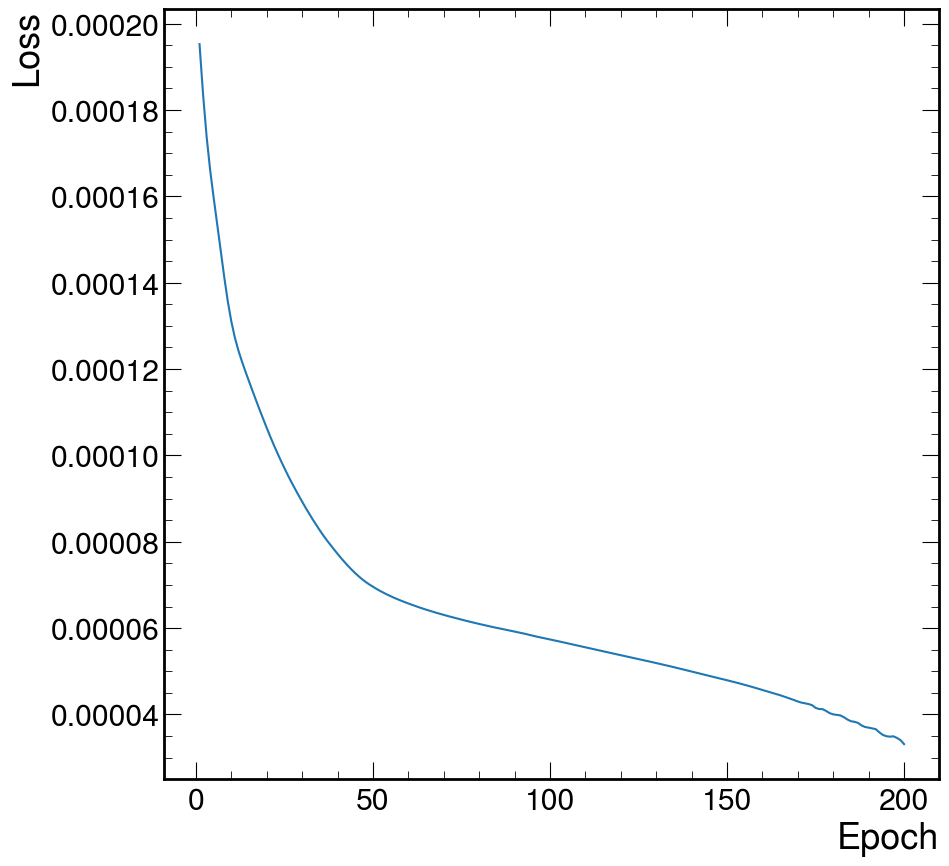

In [9]:
"""
Plot of Loss vs Epoch
"""

figure=plt.figure()
plt.plot(epochlist,lossdata)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()    

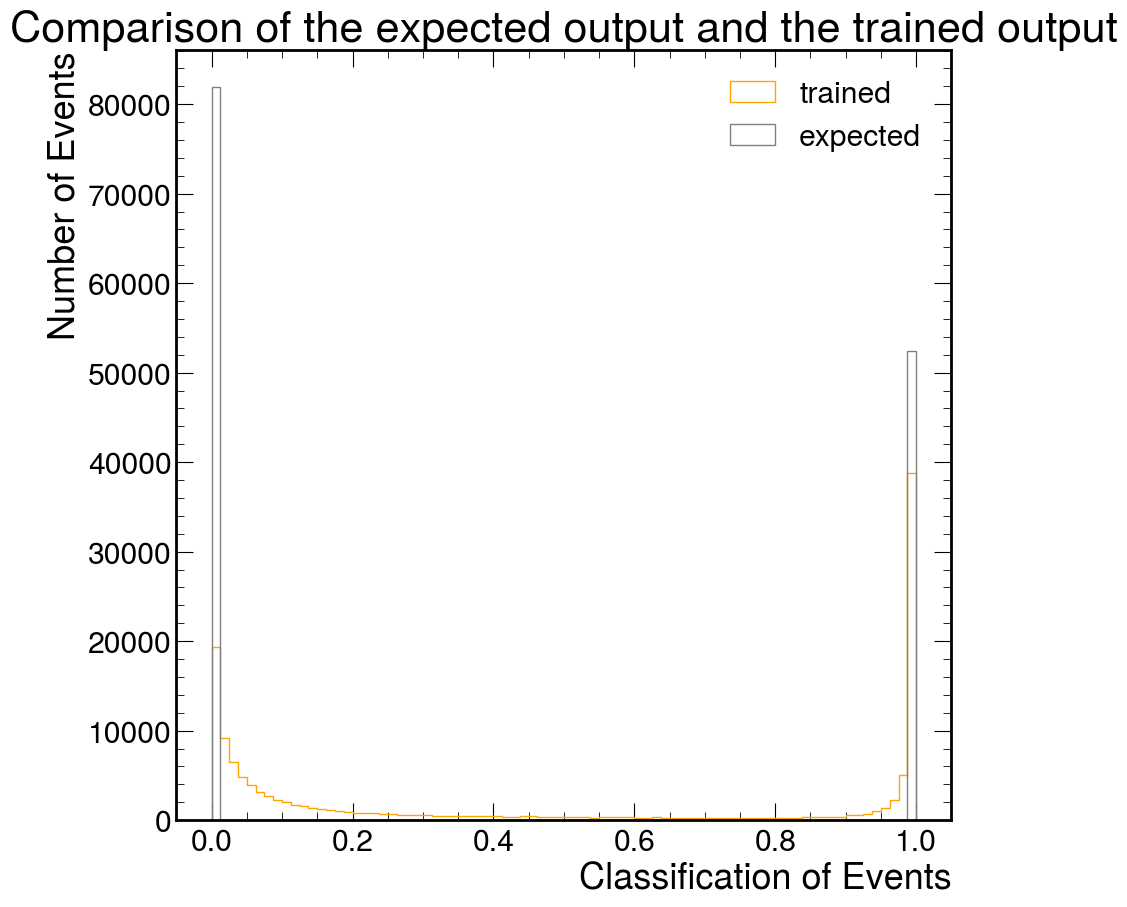

In [10]:
#epoch_= 'Epoch 99'
epoch_=f'Epoch {epochs-1}'
plt.figure()
plt.hist(df_Prediction[epoch_],bins=80,label='trained',histtype="step",color='orange')
plt.hist(train_labels,bins=80,histtype='step',color='grey',label='expected')
plt.legend()
plt.xlabel('Classification of Events')
plt.ylabel('Number of Events')
plt.title('Comparison of the expected output and the trained output')
#plt.savefig(f"BenNeuralNetworkPlots/TrainingHist-{signalname}Epochs={epochs}")
plt.show()

In [39]:
#epoch_= 'Epoch 99'
epoch_=f'Epoch {epochs-1}'
train_labels_=pd.DataFrame({'Classification': train_labels}).reset_index(drop=True)
df_Prediction = pd.concat([df_Prediction, train_labels_], axis=1)


df_Prediction.sort_values(by=[epoch_,'Classification'], ascending=True)
import scipy as scipy

#%%
direction='above' #use this to determine the side of the threshold that calculates TPR and FPR

threshold_direction = f'Signal is {direction} Background'


minimum_edge=0
maximum_edge=1
steps=1000
stepsize=(maximum_edge-minimum_edge)/steps

threshold=minimum_edge
TPR_arr = []
FPR_arr = []
for i in range(0,steps): 
    if threshold_direction == 'Signal is above Background':
        threshold += stepsize
       
        TP = len(df_Prediction[(df_Prediction[epoch_] >= threshold) & (df_Prediction['Classification']==1)][epoch_])#
        FP = len(df_Prediction[(df_Prediction[epoch_] >= threshold) & (df_Prediction['Classification']==0)][epoch_])#
        FN = len(df_Prediction[(df_Prediction[epoch_] < threshold) & (df_Prediction['Classification']==1)][epoch_])#
        TN = len(df_Prediction[(df_Prediction[epoch_] < threshold) & (df_Prediction['Classification']==0)][epoch_])#
        print('run',i)
                
        if (TP+FN) == 0:
            TPR = 0
            FPR = 0
        else:
            TPR = TP/(TP +FN)
            FPR = FP/(FP +TN)
        TPR_arr.append(TPR)
        FPR_arr.append(FPR)
        
    elif threshold_direction == 'Signal is below Background':
        threshold += stepsize
       
     #   TP = len(df_Prediction[(df_Prediction[epoch_] <= threshold) & (df_Prediction['Classification']==1)][epoch_])#
      #  FP = len(df_Prediction[(df_Prediction[epoch_] <= threshold) & (df_Prediction['Classification']==0)][epoch_])#
       # FN = len(df_Prediction[(df_Prediction[epoch_] > threshold) & (df_Prediction['Classification']==1)][epoch_])#
        #TN = len(df_Prediction[(df_Prediction[epoch_] > threshold) & (df_Prediction['Classification']==0)][epoch_])#
        
        print('run',i)
        
        TPR = TP/(TP +FN)
        FPR = FP/(FP +TN)
        TPR_arr.append(TPR)
        FPR_arr.append(FPR)
        


sorted_values = sorted(zip(FPR_arr, TPR_arr))
FPR_arr, TPR_arr = zip(*sorted_values)


run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19
run 20
run 21
run 22
run 23
run 24
run 25
run 26
run 27
run 28
run 29
run 30
run 31
run 32
run 33
run 34
run 35
run 36
run 37
run 38
run 39
run 40
run 41
run 42
run 43
run 44
run 45
run 46
run 47
run 48
run 49
run 50
run 51
run 52
run 53
run 54
run 55
run 56
run 57
run 58
run 59
run 60
run 61
run 62
run 63
run 64
run 65
run 66
run 67
run 68
run 69
run 70
run 71
run 72
run 73
run 74
run 75
run 76
run 77
run 78
run 79
run 80
run 81
run 82
run 83
run 84
run 85
run 86
run 87
run 88
run 89
run 90
run 91
run 92
run 93
run 94
run 95
run 96
run 97
run 98
run 99
run 100
run 101
run 102
run 103
run 104
run 105
run 106
run 107
run 108
run 109
run 110
run 111
run 112
run 113
run 114
run 115
run 116
run 117
run 118
run 119
run 120
run 121
run 122
run 123
run 124
run 125
run 126
run 127
run 128
run 129
run 130
run 131
run 132
run 133
run 134
run 135
run 136
run 137
run 13

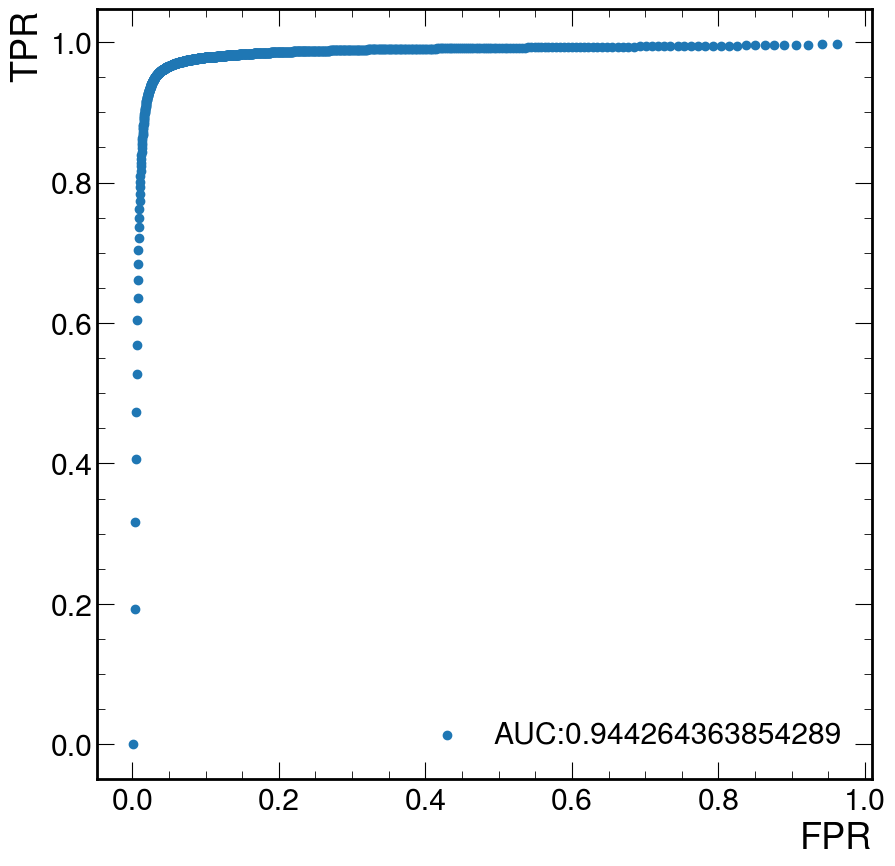

0.944264363854289


In [40]:
AUCscore=scipy.integrate.trapezoid(TPR_arr,FPR_arr,  dx=stepsize,axis=-1)
fig=plt.figure()    
plt.scatter(FPR_arr,TPR_arr,label=f'AUC:{AUCscore}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()
print(AUCscore)

In [26]:
df_Prediction = df_Prediction.drop(columns='Classification')

BenNeuralNetworkPlots/HIST_LOSS_ROC_GluGluToRadionToHHTo2G2Tau_M-1000Epochs=200


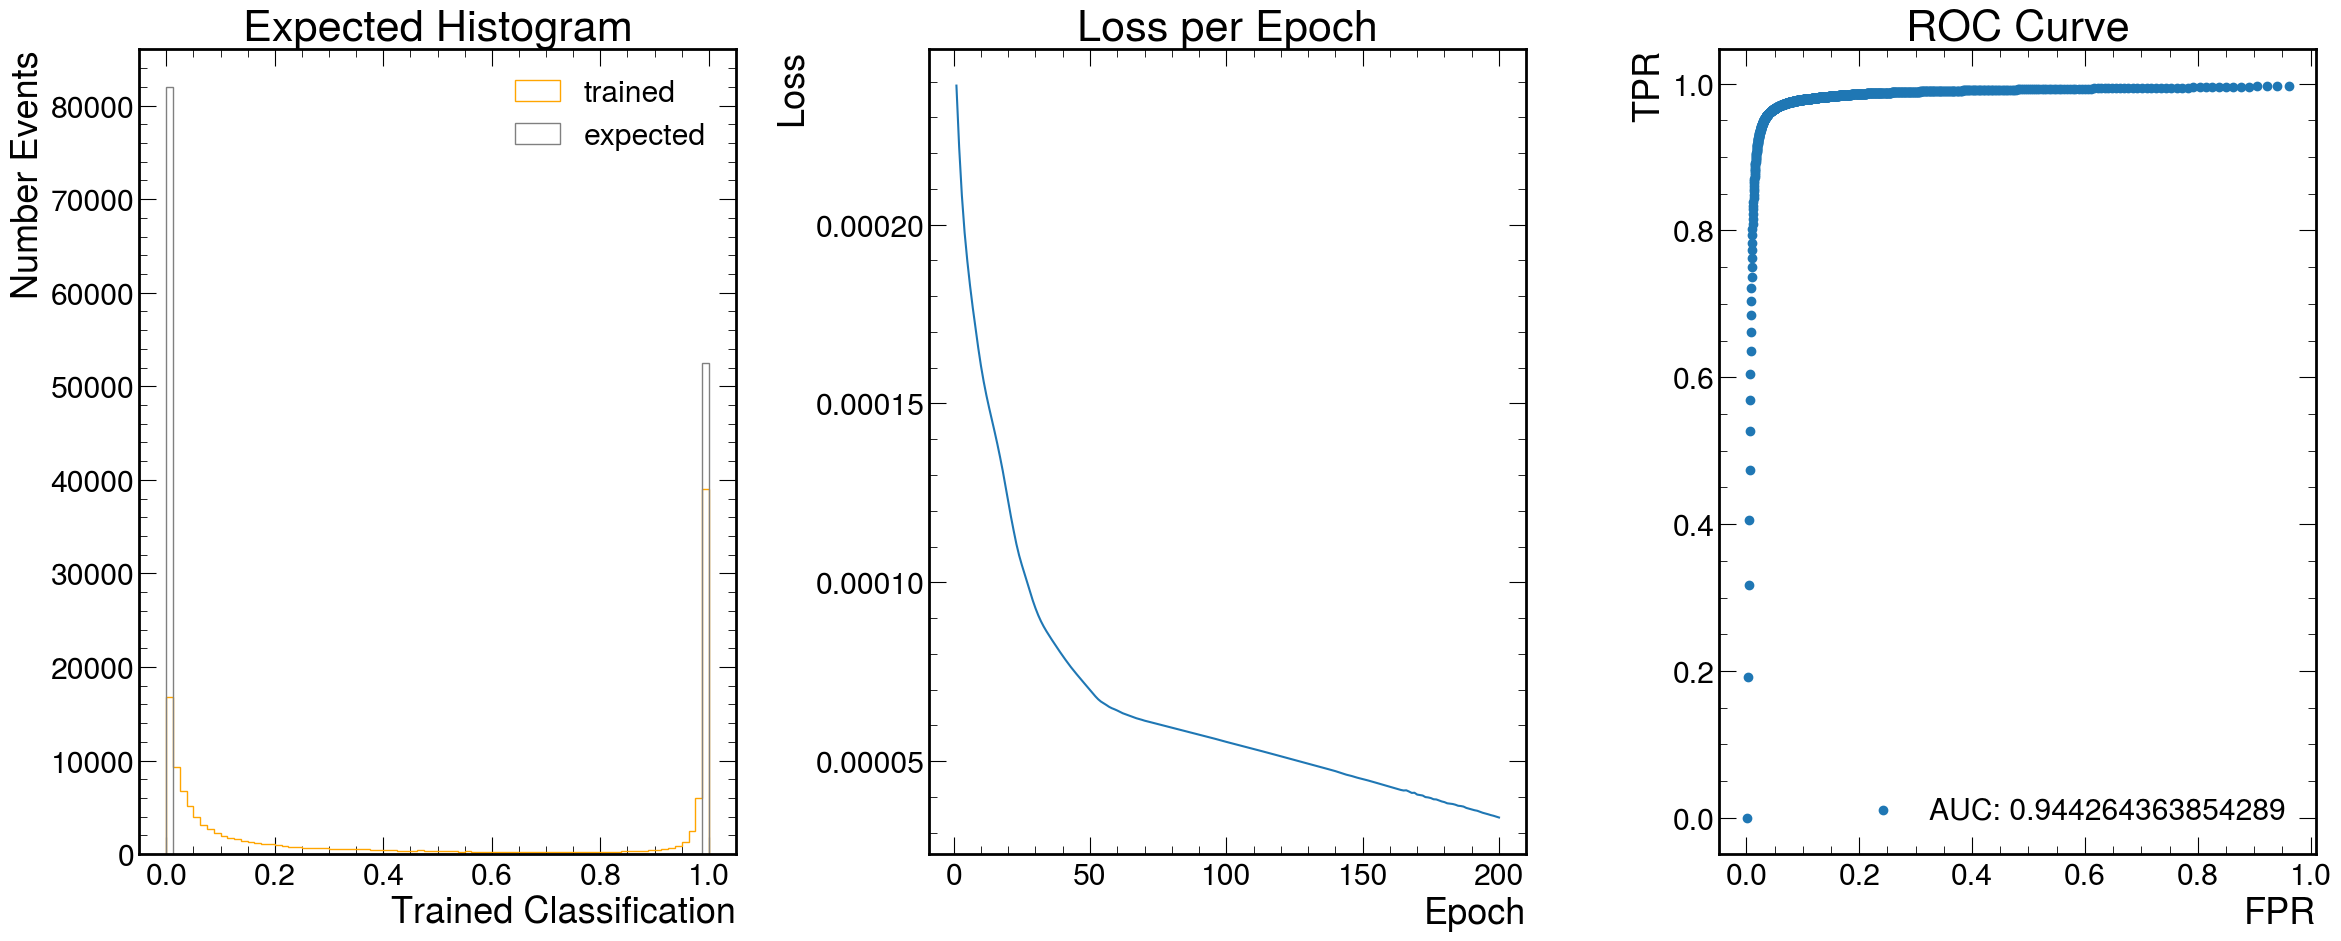

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(24, 10))

# Plot 1: Line plot (plt.plot)
axs[1].plot(epochlist, lossdata)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss per Epoch')

# Plot 2: Histograms (two separate subplots)
axs[0].hist(df_Prediction[epoch_], bins=80, label='trained', histtype="step", color='orange')
axs[0].legend()
axs[0].set_title('Trained Histogram')

axs[0].set_xlabel('Trained Classification')
axs[0].set_ylabel('Number Events')

axs[0].hist(train_labels, bins=80, histtype='step', color='grey', label='expected')
axs[0].legend()
axs[0].set_title('Expected Histogram')

# Plot 3: Scatter plot with AUC score
axs[2].scatter(FPR_arr, TPR_arr, label=f'AUC: {AUCscore}')
axs[2].set_xlabel('FPR')
axs[2].set_ylabel('TPR')
axs[2].legend()
axs[2].set_title('ROC Curve')

# Adjust layout and display
plt.tight_layout()
plt.savefig(f"BenNeuralNetworkPlots/HIST_LOSS_ROC_{signalname}Epochs={epochs}")
print(f"BenNeuralNetworkPlots/HIST_LOSS_ROC_{signalname}Epochs={epochs}")

plt.show()


In [28]:
epochs

200

In [256]:
epoch_

'Epoch 199'

In [257]:
print(df_Prediction[epoch_].shape,train_labels.shape)

(120084,) (120084,)
